<a href="https://colab.research.google.com/github/asheshbyanju/recolorizing_images/blob/master/recolorizing_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import glob
from PIL import Image
from skimage.color import rgb2lab, lab2rgb
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [108]:
# Loading Data
# taking all images and spliting it into train and validation
root_paths = glob.glob("/content/drive/MyDrive/ColabNotebooks/datasets-colornet/images/Train/asd/*.jpg") + glob.glob("/content/drive/MyDrive/ColabNotebooks/datasets-colornet/images/Train/asd/*.jpeg")
np.random.seed(0)
rand_indexs = np.random.permutation(9294)
train_indexs = rand_idxs[:7435] # choosing random 80% as training set
val_indexs = rand_idxs[7435:] # choosing random 20% as validation set
train_paths = np.array(root_paths)[train_idxs]
val_paths = np.array(root_paths)[val_idxs]
print(len(train_paths), len(val_paths))

# for test
test_dir = "/content/drive/MyDrive/ColabNotebooks/datasets-colornet/images/Test" 


7435 1859


In [111]:
class ColornetDataset(Dataset):

  def __init__(self, paths, transform):
    self.paths = paths
    self.transform = transform

  def __getitem__(self, idx):
    img = Image.open(self.paths[idx]).convert("RGB")
    img = self.transform(img)
    img = np.array(img)
    img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
    img_lab = transforms.ToTensor()(img_lab)
    L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
    ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1

    return {'L': L, 'ab': ab}


  def __len__(self):
    return len(self.paths)


In [113]:
# Image transform for train and validation
train_transform = transforms.Compose([transforms.Resize([256,256]), transforms.RandomHorizontalFlip()])
val_transform = transforms.Compose([transforms.Resize([256,256])])

# Image transform for test
test_transform = transforms.Compose([transforms.Resize([256,256]), transforms.ToTensor()])

#loading datasets
train_data = ColornetDataset(paths = train_paths, transform = train_transform)
# print(len(train_data))

val_data = ColornetDataset(paths = val_paths, transform = train_transform)
# print(len(val_data))

test_data = datasets.ImageFolder(test_dir, transform=test_transform)
# ColornetDataset(paths = test_paths, transform = test_transform)
# print(len(test_data))

train_load = DataLoader(train_data, batch_size=32)
val_load = DataLoader(val_data, batch_size=32)
test_load = DataLoader(test_data, batch_size=32)


7435
1859
494


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [68]:
data = next(iter(train_load))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)

torch.Size([32, 1, 256, 256]) torch.Size([32, 2, 256, 256])


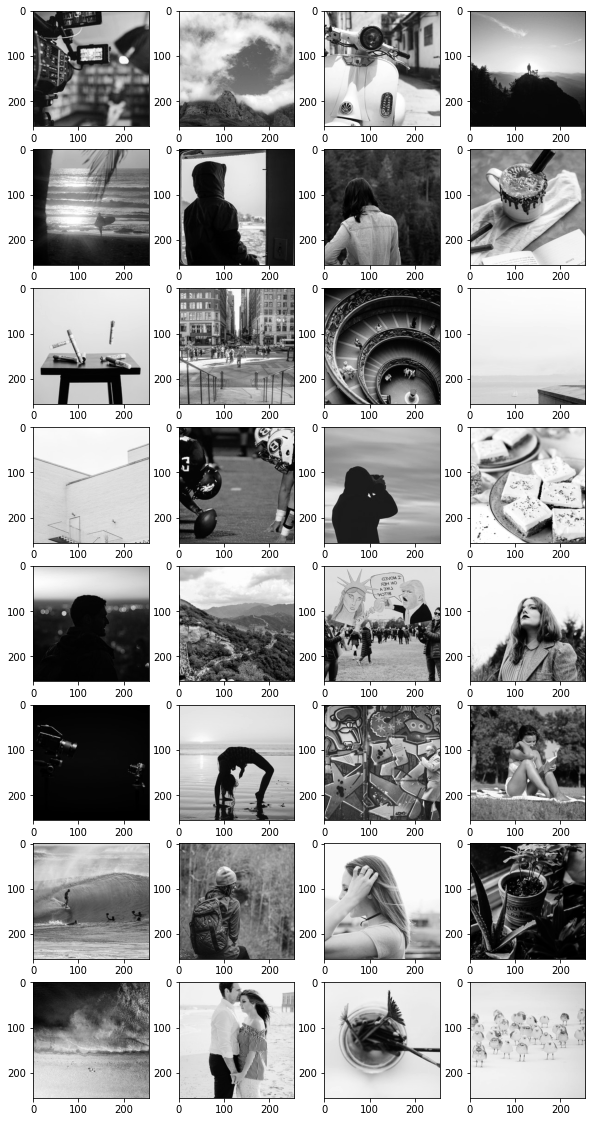

In [107]:
# viewing train images to see if they are loaded correctly

images = next(iter(train_load))

plt.figure(figsize=(10,20))

for i in range(32):
    img = np.squeeze(images['L'][i].permute(1,2,0))
    plt.subplot(8,4,i+1)
    plt.imshow(img, cmap='gray')

plt.show()

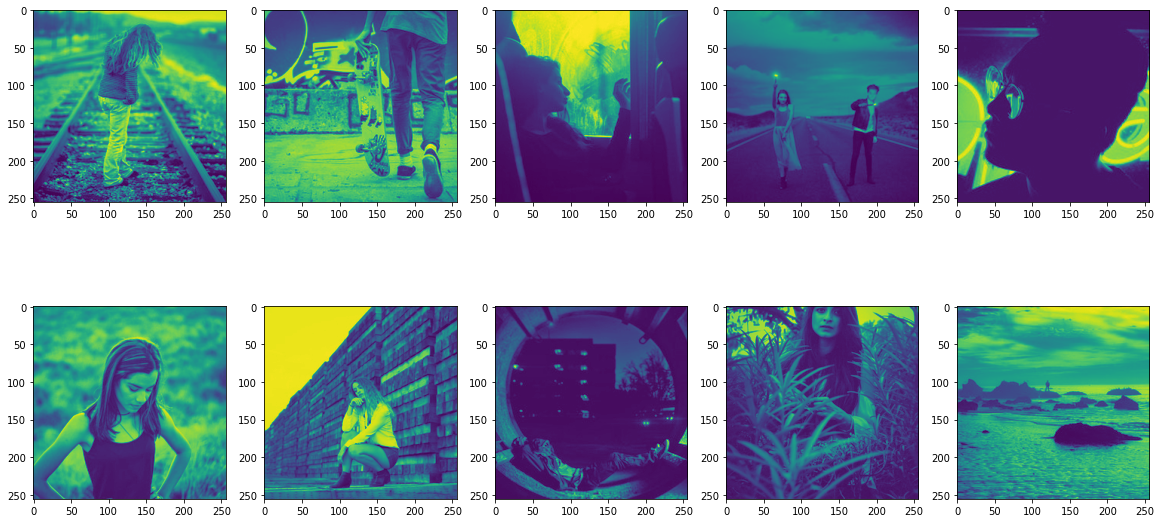

In [136]:
# viewing train images to see if they are loaded correctly

images = next(iter(val_load))

plt.figure(figsize=(20,10))

for i in range(10):
    img = np.squeeze(images['L'][i].permute(1,2,0))
    plt.subplot(2,5,i+1)
    plt.imshow(img)

plt.show()

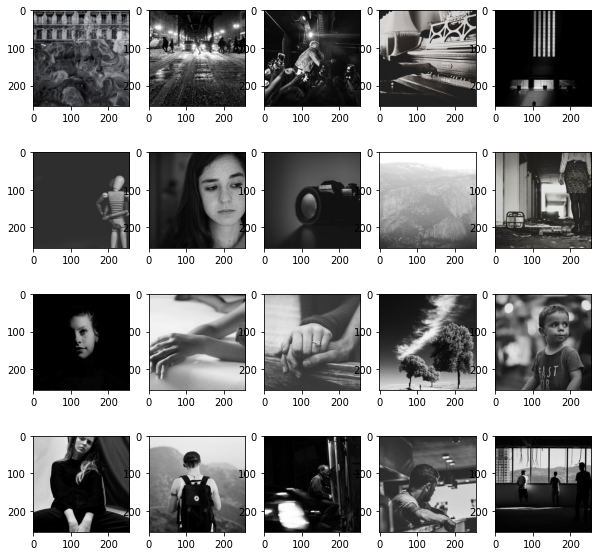

In [115]:
# viewing test images to see if they are loaded correctly

iteration = iter(test_load)
images, _ = next(iteration)

plt.figure(figsize=(10,10))

for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(images[i].permute(1,2,0))

plt.show()

**Building a Model**

In [8]:
def upsample(c_in, c_out, dropout=False):
  result = nn.Sequential()
  result.add_module('con', nn.ConvTranspose2d(c_in, c_out, kernel_size=4, stride=2, padding=1, bias=False))
  result.add_module('bat',nn.BatchNorm2d(c_out))
  if dropout:
    result.add_module('drop',nn.Dropout2d(0.5, inplace=True))
  result.add_module('relu',nn.ReLU(inplace=True))

  return result

In [9]:
def downsample(c_in, c_out, batchnorm=True):
  result = nn.Sequential()
  result.add_module('con', nn.Conv2d(c_in, c_out, kernel_size=4, stride=2, padding=1, bias=False))
  
  if batchnorm:
    result.add_module('batc',nn.BatchNorm2d(c_out))
  result.add_module('LRelu',nn.LeakyReLU(0.2, inplace=True))

  return result

# **Building a Network**

### Building a Discriminator

In [24]:
class Discriminator(nn.Module):
  def __init__(self, n_channels=3, n_feature=64):
    super(Discriminator, self).__init__()

    main = nn.Sequential()
    main.add_module('conv1',nn.Conv2d(n_channels, n_feature, kernel_size=4, stride=2, padding=1, bias=False))
    
    main.add_module('ds1',downsample(n_feature, n_feature*2))
    
    n_feature = n_feature*2
    main.add_module('ds2',downsample(n_feature, n_feature*2))
    
    n_feature = n_feature*2
    main.add_module('LRelu',nn.LeakyReLU(0.2, inplace=True))
    main.add_module('conv2',nn.Conv2d(n_feature, n_feature*2, kernel_size=4, stride=1, padding=1, bias=False))
    main.add_module('batch',nn.BatchNorm2d(n_feature*2))
    
    n_feature = n_feature*2
    main.add_module('LRelu',nn.LeakyReLU(0.2, inplace=True))
    main.add_module('conv3', nn.Conv2d(n_feature, 1, kernel_size=4, stride=1, padding=1, bias=False))
    main.add_module('sig', nn.Sigmoid())

    self.main = main


  def forward(self, input):
    x = self.main(input)

    return x

In [25]:
d = Discriminator(3, 64)
print(d)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = d(dummy_input)
out.shape

Discriminator(
  (main): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (ds1): Sequential(
      (con): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (batc): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (LRelu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (ds2): Sequential(
      (con): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (batc): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (LRelu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (LRelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv2): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (batch): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1),

torch.Size([16, 1, 30, 30])

### Building a Generator

In [14]:
class Generator(nn.Module):
  def __init__(self, input_nc=1, output_nc=2, n_feature=64):
    super(Generator, self).__init__()


    layer1 = nn.Conv2d(input_nc, n_feature, kernel_size=4, stride=2, padding=1, bias=False)
    layer2 = downsample(n_feature,n_feature*2)
    layer3 = downsample(n_feature*2, n_feature*4)
    layer4 = downsample(n_feature*4, n_feature*8)
    layer5 = downsample(n_feature*8, n_feature*8)
    layer6 = downsample(n_feature*8, n_feature*8)
    layer7 = downsample(n_feature*8, n_feature*8)
    layer8 = downsample(n_feature*8, n_feature*8)

    #decoder
    d_inc = n_feature*8
    dlayer8 = upsample(d_inc, n_feature*8, dropout=True)
    d_inc = n_feature*8*2
    dlayer7 = upsample(d_inc, n_feature*8, dropout=True)
    d_inc = n_feature*8*2
    dlayer6 = upsample(d_inc, n_feature*8, dropout=True)
    d_inc = n_feature*8*2
    dlayer5 = upsample(d_inc, n_feature*8)
    d_inc = n_feature*8*2
    dlayer4 = upsample(d_inc, n_feature*4)
    d_inc = n_feature*4*2
    dlayer3 = upsample(d_inc, n_feature*2)
    d_inc = n_feature*2*2
    dlayer2 = upsample(d_inc, n_feature)
    
    dlayer1 = nn.Sequential()
    d_inc = n_feature*2
    dlayer1.add_module('relu', nn.ReLU(inplace=True))
    dlayer1.add_module('t_conv', nn.ConvTranspose2d(d_inc, output_nc, kernel_size=4, stride=2, padding=1, bias=False))
    dlayer1.add_module('tanh', nn.Tanh())

    self.layer1 = layer1
    self.layer2 = layer2
    self.layer3 = layer3
    self.layer4 = layer4
    self.layer5 = layer5
    self.layer6 = layer6
    self.layer7 = layer7
    self.layer8 = layer8
    self.dlayer8 = dlayer8
    self.dlayer7 = dlayer7
    self.dlayer6 = dlayer6
    self.dlayer5 = dlayer5
    self.dlayer4 = dlayer4
    self.dlayer3 = dlayer3
    self.dlayer2 = dlayer2
    self.dlayer1 = dlayer1


  def forward(self, input):
    out1 = self.layer1(input)
    out2 = self.layer2(out1)
    out3 = self.layer3(out2)
    out4 = self.layer4(out3)
    out5 = self.layer5(out4)
    out6 = self.layer6(out5)
    out7 = self.layer7(out6)
    out8 = self.layer8(out7)
    dout8 = self.dlayer8(out8)
    dout8_out7 = torch.cat([dout8, out7], 1)
    dout7 = self.dlayer7(dout8_out7)
    dout7_out6 = torch.cat([dout7, out6], 1)
    dout6 = self.dlayer6(dout7_out6)
    dout6_out5 = torch.cat([dout6, out5], 1)
    dout5 = self.dlayer5(dout6_out5)
    dout5_out4 = torch.cat([dout5, out4], 1)
    dout4 = self.dlayer4(dout5_out4)
    dout4_out3 = torch.cat([dout4, out3], 1)
    dout3 = self.dlayer3(dout4_out3)
    dout3_out2 = torch.cat([dout3, out2], 1)
    dout2 = self.dlayer2(dout3_out2)
    dout2_out1 = torch.cat([dout2, out1], 1)
    dout1 = self.dlayer1(dout2_out1)
    return dout1



In [22]:
g = Generator(1,2,64)

print(g)
dummy_input = torch.randn(16, 1, 256, 256) # batch_size, channels, size, size
out = g(dummy_input)
out.shape

Generator(
  (layer1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (layer2): Sequential(
    (con): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batc): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (LRelu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer3): Sequential(
    (con): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batc): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (LRelu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer4): Sequential(
    (con): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batc): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (LRelu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer5): Sequential(
    (con): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding

torch.Size([16, 2, 256, 256])

In [ ]:
image,labels = next(iter(train_load))

class_score = g(image)

print(class_score.shape)

torch.Size([50, 3, 256, 256])


In [ ]:
class_score

tensor([[[[ 2.3727e-01, -5.3137e-01,  4.4018e-02,  ..., -4.7960e-01,
            1.9168e-01, -2.4678e-01],
          [-5.1061e-02, -3.1196e-01, -5.6276e-01,  ..., -8.3114e-01,
            4.0975e-01, -4.5294e-01],
          [ 2.5784e-01, -6.4804e-01,  2.4968e-01,  ..., -6.5391e-01,
           -2.2577e-01, -6.3956e-01],
          ...,
          [ 5.4919e-02, -9.1952e-01,  4.3774e-01,  ..., -6.6884e-01,
            1.8371e-01, -2.3395e-02],
          [-1.8228e-01, -6.0215e-01, -1.8838e-01,  ..., -7.2712e-01,
            4.4699e-01,  1.5520e-01],
          [ 2.5857e-01, -4.4452e-02,  5.5757e-01,  ..., -5.7207e-01,
            5.2081e-01, -2.6397e-01]],

         [[-1.5359e-01, -5.3933e-02,  4.4707e-02,  ..., -2.6731e-01,
           -5.8932e-01,  3.5842e-01],
          [ 3.1188e-01, -8.2522e-01,  7.0294e-01,  ..., -7.4421e-01,
            8.9451e-01, -1.6470e-01],
          [ 2.2880e-01, -2.2653e-02, -1.3872e-01,  ..., -6.7227e-01,
           -5.4993e-01,  2.2772e-01],
          ...,
     

In [156]:
torch.FloatTensor(12)

tensor([1.8398e+27, 3.0962e-41, 2.3694e-38, 1.5924e-05, 1.0842e-19, 3.8177e-05,
        1.0842e-19, 3.8177e-05, 1.0842e-19, 3.8177e-05, 3.9415e+12, 7.5338e+28])

In [4]:
torch.cuda.is_available()

True